# Modeling Extremes - From Scratch

In [80]:
import autoroot
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import seaborn as sns
import regionmask
from pyextremes import get_extremes, get_return_periods
from pyextremes.plotting import plot_extremes
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [84]:
from bayesevt._src.data.local import DATASET_SPAIN_ANOMALIES

ds = xr.open_mfdataset(DATASET_SPAIN_ANOMALIES["t2max"])

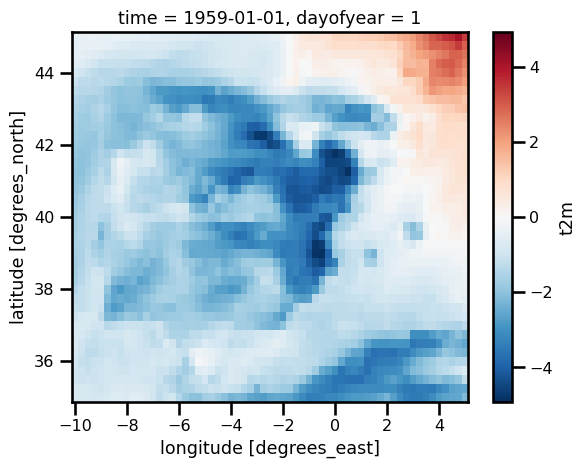

In [88]:
ds.t2m.isel(time=0).plot.pcolormesh()

## Masking

In [93]:
from bayesevt._src.geoprocessing.masks import add_country_mask, add_land_mask


In [ ]:
ds = add_country_mask(ds, country="Spain")
ds = add_land_mask(ds)

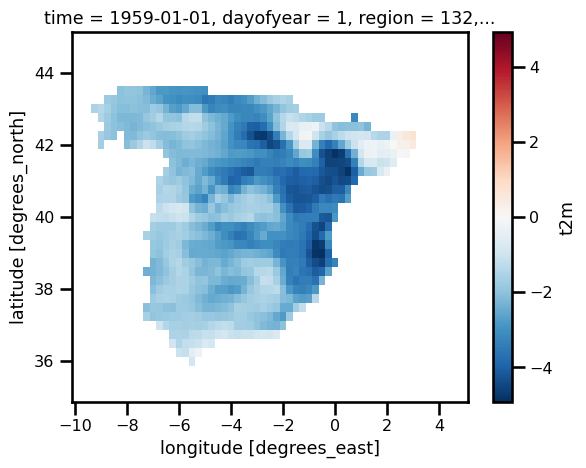

In [94]:

ds.where(ds.spain_mask==1).isel(time=0).t2m.plot()

## Clean Data

* Take Weighted Mean
* Convert Kelvin to Celsius
* Convert to DataFrame & Series
* Drop NANS
* Sort according to time
* Small Correction to Date

In [8]:
# # take weighted spatial mean
# import numpy as np
# weights = spain_mask.squeeze() * np.cos(np.deg2rad(ds.latitude))
# ds = xr.open_mfdataset(data_url)
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"]) - 272.15

### Region Selection

We are going to select Spain but also perhaps Madrid.

In [127]:
# # take weighted spatial mean
# weights = ds["spain_mask"] * np.cos(np.deg2rad(ds.latitude))
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"])

# select MADRID region
data = ds.sel(longitude=-3.703790, latitude=40.416775, method="nearest")

In [128]:

# # convert Kelvin to Celcius
# data -= 272.15
# convert to dataframe
data = data.t2m.to_dataframe()
# create time series
data = pd.Series(data["t2m"])
# remove nans
data = data.dropna()
# sort ascending
data = data.sort_index(ascending=True)
# # start time
t0 = data.index[0]
# # rescale time
data = data - (data.index.array - pd.to_datetime(t0.year)) / pd.to_timedelta("365.2425D") * 2.87e-3
data.describe()

count    23011.000000
mean        -0.382247
std          3.740105
min        -16.210242
25%         -2.915719
50%         -0.283981
75%          2.215052
max         12.947272
Name: t2m, dtype: float64

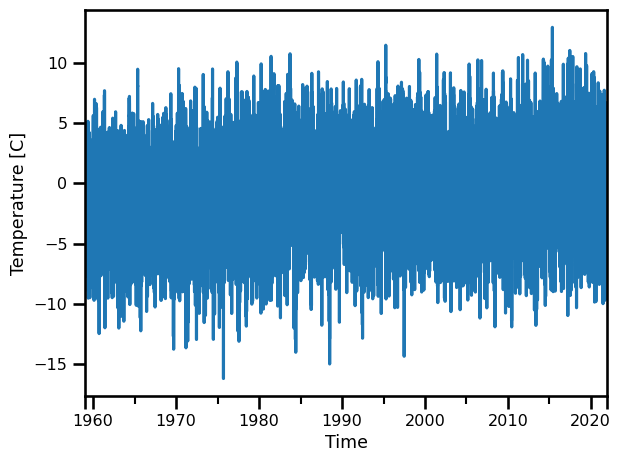

In [129]:
fig, ax = plt.subplots()

data.plot(ax=ax)

ax.set(
    xlabel="Time",
    ylabel="Temperature [C]"
)
plt.tight_layout()
plt.show()

## Extremes

In [142]:
extremes_method = "BM" # 
block_size = "365.2425D" # f"{3*30}D" # 
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
    
)

In [132]:
extremes_method = "POT" # "BM" # 
extremes_type = "high"
threshold = np.quantile(data.values, q=0.98)
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    threshold=threshold
    
)

/home/juanjohn/miniconda/envs/bayesevt_ai/lib/python3.10/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)


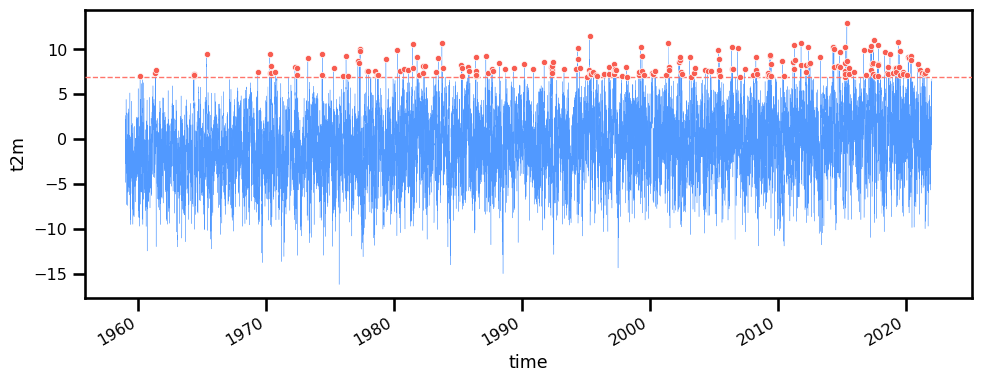

In [133]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

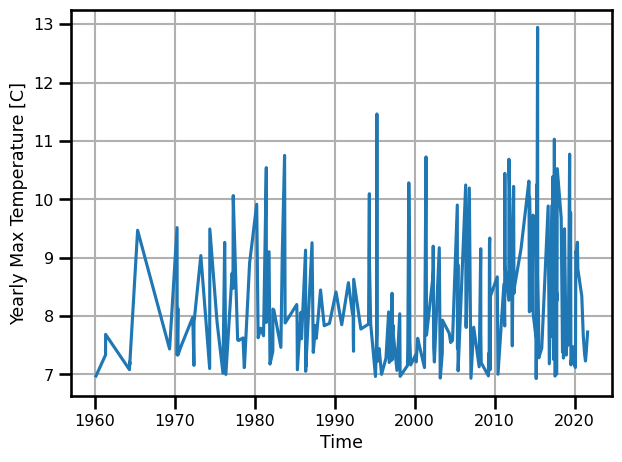

In [134]:
fig, ax = plt.subplots()

ax.plot(extremes)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]"
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.show()

## Diagnostics

In [135]:
extremes_method = "BM" # 
block_size = "365.2425D" # f"{3*30}D" # 
extremes_type = "high"

return_periods = get_return_periods(
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type,
    block_size=block_size,
    return_period_size=block_size,
    plotting_position="weibull",
)
# 
return_periods = return_periods.sort_values(by="return period", ascending=False)

In [139]:
extremes_method = "POT" # "BM" # 
extremes_type = "high"
threshold = np.quantile(data.values, q=0.95)
return_period_size = "365.2425D"

return_periods = get_return_periods(
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type,
    return_period_size=return_period_size,
    plotting_position="weibull",
)
# 
return_periods = return_periods.sort_values(by="return period", ascending=False)

In [140]:
return_periods

,t2m,exceedance probability,return period
time,,,
2015-05-13,12.947272,0.004505,63.284305
1995-04-10,11.463034,0.009009,31.642152
2017-06-17,11.030958,0.013514,21.094768
2019-05-15,10.774879,0.018018,15.821076
1983-09-25,10.752610,0.022523,12.656861
...,...,...,...
1998-03-07,6.968279,0.977477,0.291633
1995-02-05,6.966238,0.981982,0.290295
2003-03-13,6.938651,0.986486,0.288969


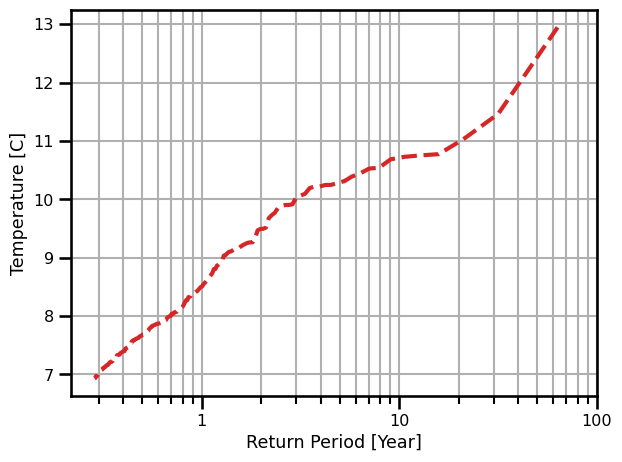

In [141]:
fig, ax = plt.subplots()

ax.plot(
    return_periods["return period"],
    return_periods["t2m"], 
    linestyle="--", linewidth=3, color="tab:red"
    
)
ax.set(
    xlabel="Return Period [Year]",
    ylabel="Temperature [C]",
    xscale="log",
    xticks=[1.0, 10.0, 100.0]
    
)

# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)

plt.tight_layout()
plt.show()